In [11]:
#Creating a computer vision program to identify the sports between Rugby and Soccer

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import numpy as np
import cv2
import os


In [12]:
#Defining the data

#Pre-label the options for classification
labels = ['rugby', 'soccer']

#Pre-define the image pixel size
img_size = 224

#Create a function that pulls the data into an array and and reads the images associated with the labels from the files they are stored within
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype= object)




In [13]:
#Now we can easily fetch our train and validation data.
train = get_data('/kaggle/input/football-vs-rugby-image-classification/input/train')
test = get_data('/kaggle/input/football-vs-rugby-image-classification/input/test')

In [14]:
train[1]


array([array([[[ 60,  71,  65],
               [ 57,  68,  64],
               [ 66,  77,  73],
               ...,
               [ 76,  86,  81],
               [ 77,  89,  84],
               [ 83,  95,  91]],

              [[ 58,  69,  63],
               [ 55,  66,  62],
               [ 63,  74,  70],
               ...,
               [ 70,  82,  75],
               [ 76,  87,  83],
               [ 80,  91,  87]],

              [[ 57,  68,  64],
               [ 56,  67,  63],
               [ 61,  71,  70],
               ...,
               [ 67,  83,  73],
               [ 71,  82,  79],
               [ 78,  87,  86]],

              ...,

              [[106, 139,  57],
               [109, 141,  65],
               [114, 146,  73],
               ...,
               [136, 158,  86],
               [130, 153,  83],
               [134, 160,  90]],

              [[108, 144,  58],
               [105, 137,  61],
               [116, 147,  77],
               ...,
        

<Axes: ylabel='count'>

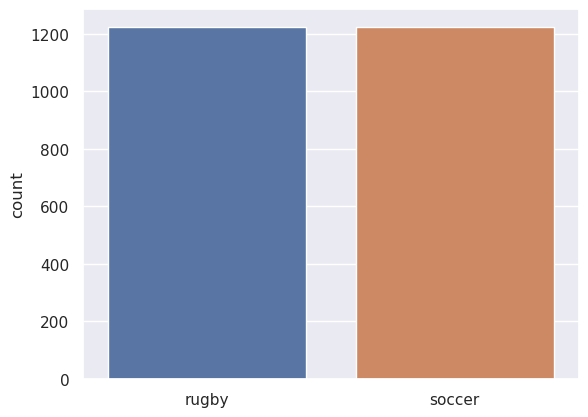

In [15]:
#Visualize how much data is in each training set

def display_counts(data):
    l = []
    for i in data:
        if(i[1] == 0):
            l.append("rugby")
        else:
            l.append("soccer")
    sns.set_theme(style="darkgrid")
    return sns.countplot(x=l)

#Create the list of dataframes to cycle count through
datasets = [train, test]

display_counts(train)

Text(0.5, 1.0, 'rugby')

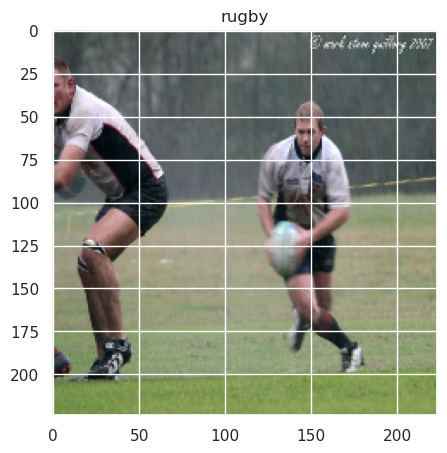

In [16]:
#Test for the rugby images
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'soccer')

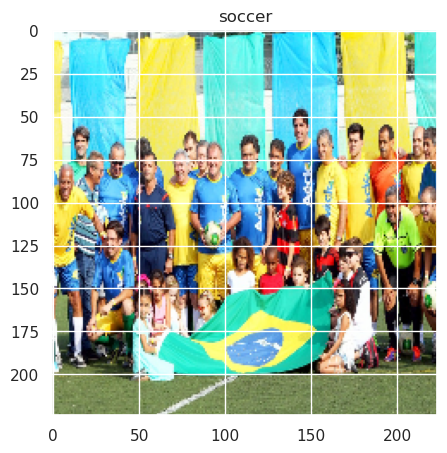

In [17]:
#Similarly test for the soccer images
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [18]:
#Pre-processing the images to split into training and testing buckets

x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in test:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [9]:
#Apply augmentation to the data model to make the training more robust

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [29]:
#Build the CNN Model layers

model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 28, 28, 64)      

In [175]:
#Define optimizer and loss function
opt = Adam(learning_rate=0.000001)
model.compile(optimizer = opt , 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , 
              metrics = ['accuracy'])

In [176]:
#Train the model over 500 epochs and then store the parameters in history

history = model.fit(x_train,y_train,epochs = 50 , validation_data = (x_val, y_val))

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


77/77 [==============================] - 105s 1s/step - loss: 0.6901 - accuracy: 0.5368 - val_loss: 0.6865 - val_accuracy: 0.5754
Epoch 2/50
77/77 [==============================] - 104s 1s/step - loss: 0.6880 - accuracy: 0.5384 - val_loss: 0.6823 - val_accuracy: 0.6213
Epoch 3/50
77/77 [==============================] - 104s 1s/step - loss: 0.6873 - accuracy: 0.5519 - val_loss: 0.6782 - val_accuracy: 0.6410
Epoch 4/50
77/77 [==============================] - 104s 1s/step - loss: 0.6844 - accuracy: 0.5621 - val_loss: 0.6749 - val_accuracy: 0.6475
Epoch 5/50
77/77 [==============================] - 104s 1s/step - loss: 0.6825 - accuracy: 0.5735 - val_loss: 0.6723 - val_accuracy: 0.6541
Epoch 6/50
77/77 [==============================] - 106s 1s/step - loss: 0.6809 - accuracy: 0.5780 - val_loss: 0.6683 - val_accuracy: 0.6623
Epoch 7/50
77/77 [==============================] - 104s 1s/step - loss: 0.6787 - accuracy: 0.5862 - val_loss: 0.6647 - val_accuracy: 0.6607
Epoch 8/50
77/77 [======

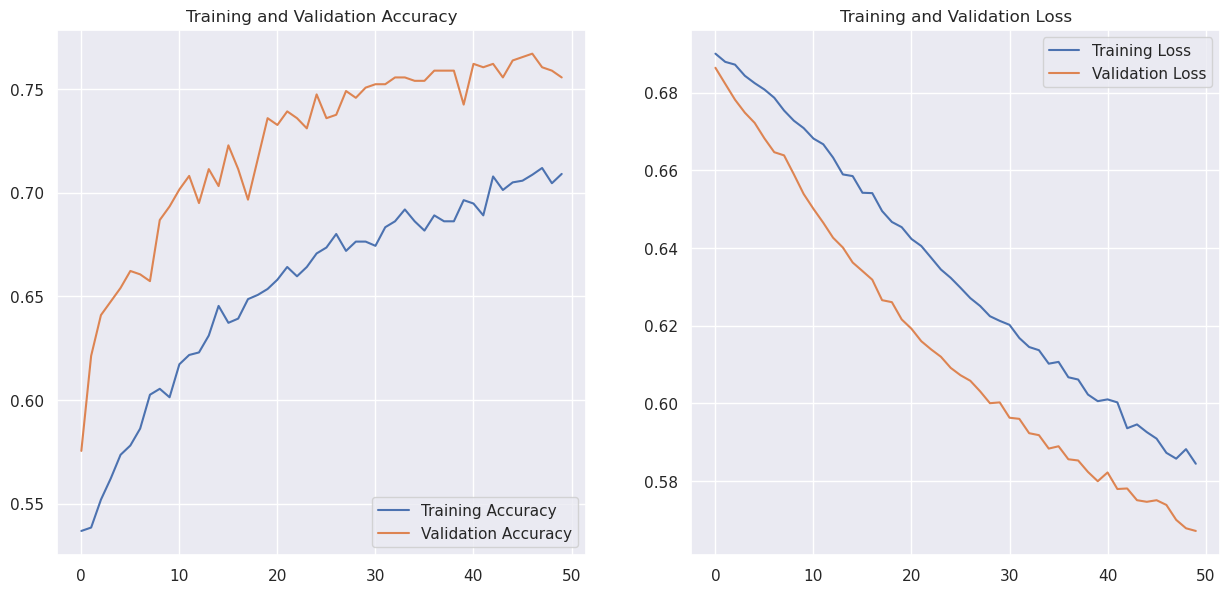

In [178]:
#Evaluate the model training

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [179]:
#predictions = model.predict_classes(x_val)
preds = model.predict(x_val)
print(preds)

20/20 [==============================] - 7s 327ms/step
[[0.7023696  0.2976305 ]
 [0.53962576 0.4603742 ]
 [0.71760434 0.28239557]
 ...
 [0.35813656 0.64186347]
 [0.38455755 0.61544245]
 [0.61229193 0.3877081 ]]


In [180]:
#Determine what the predicition is from the model

def whats_the_guess(predictions):
    array_of_preds =[]
    for i in predictions:
        max_value = 0
        if preds[0][0] > preds[0][1]:
            max_value = preds[0][0]
        else:
            max_value = preds[0][1]
        array_of_preds.append(np.where(preds[0]==max_value)[0][0])
    return array_of_preds

<Axes: ylabel='count'>

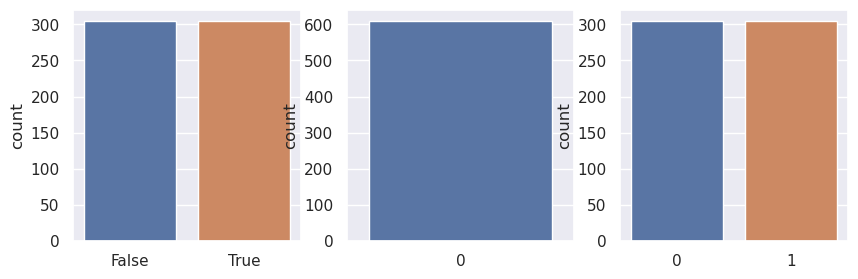

In [181]:
list_of_preds = whats_the_guess(preds)

correct_array = list_of_preds == y_val

correct_array
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
sns.set_theme(style="darkgrid")
sns.countplot(x=correct_array)

#plt.figure(figsize=(5, 3))
plt.subplot(1, 3, 2)
sns.set_theme(style="darkgrid")
sns.countplot(x=list_of_preds)

plt.subplot(1, 3, 3)
sns.set_theme(style="darkgrid")
sns.countplot(x=y_val)

In [182]:
true_vals = 0

for i in correct_array:
    if i == True:
        true_vals += 1
        
true_vals/len(correct_array)

0.5

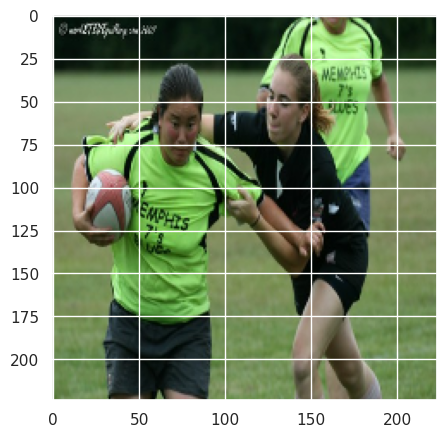

In [61]:
#Similarly test for the soccer images
plt.figure(figsize = (5,5))
plt.imshow(x_val[1])
#plt.title(labels[x[-1][1]])